In [1]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import json
import warnings

# Set charting paramaters
plt.style.use('ggplot')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
pd.set_option('display.max_colwidth', 0)
warnings.filterwarnings('ignore')

In [2]:
min_amenities = 1
chosen_new = ['hostel', 'university', 'dormitory']
label_new = "night snacks"

In [6]:
# Assume that amenities has been generated from GIS data on a monthly basis
amenities = pd.read_csv('../data/amenities.csv').drop(['Unnamed: 0'], axis=1)
amenities = amenities.rename(columns={'HubName':'CustomerCode', 'HubDist':'CustomerDist'})
amenity_names = amenities['type'].unique().tolist()

In [8]:
# Display the existing demographic mapping
with open('../data/mapping.json', 'r') as f:
    mapping_dict = json.load(f)
if len(label_new) > 0:
    mapping_dict[label_new] = chosen_new
labels = [k for k in mapping_dict.keys()] 
sets = [v for v in mapping_dict.values()] 
mapping = pd.DataFrame({
    "Demographic Label": labels,
    "Amentities Chosen": sets
})

### These are the demographic labels being analyzed

In [9]:
mapping

,Demographic Label,Amentities Chosen
0,students,"[fast_food, dormitory, tuition_school, internet_cafe, school, hostel, university]"
1,white-collar,"[restaurant, department_store, mall, spa, fitness_centre]"
2,blue-collar,"[bicycle, bicycle_parking, construction]"
3,night snacks,"[hostel, university, dormitory]"


In [10]:
# Index by customer to see how many of each amenity it is located close to
by_customer = amenities.groupby(['CustomerCode', 'type'])['CustomerDist'].size().unstack().reset_index().fillna(0).set_index('CustomerCode')

In [11]:
# Calculate the number of amenities for each store 
for k,v in mapping_dict.items():
    by_customer[k] = (by_customer[v].sum(axis=1) >= min_amenities)

In [13]:
filtered = pd.read_csv('../data/sample_demographic.csv')
filtered['InvoiceMonth'] = filtered['InvoiceDate'].astype(str).str[:6]

In [14]:
# Get transactions data from the transactions table
stats = (filtered
.groupby(['CustomerCode', 'InvoiceMonth'])
.agg({
    'InvoiceNumber': ['nunique'],
    'NetAmount': ['sum'],
    'ProductCode': ['nunique']
}))
stats = stats.droplevel(1, axis=1)
stats.columns = ['Unique Invoices', 'Total Amount Spent', 'Count of Distinct SKUs']
stats_new = stats.groupby(level='CustomerCode').mean()

In [15]:
# Merge the transactons data with the amenities data
final = by_customer.join(stats_new)

In [16]:
final_df = pd.DataFrame(index = labels)
metrics = ['Store Count', 'Unique Invoices', 'Total Amount Spent', 'Count of Distinct SKUs']
for m in metrics:
    tmp = []
    for l in labels:
        if m == 'Store Count':
            tmp.append(final[l].sum())
        else:
            tmp.append(final[final[l] == True][m].mean())
    final_df[m] = tmp

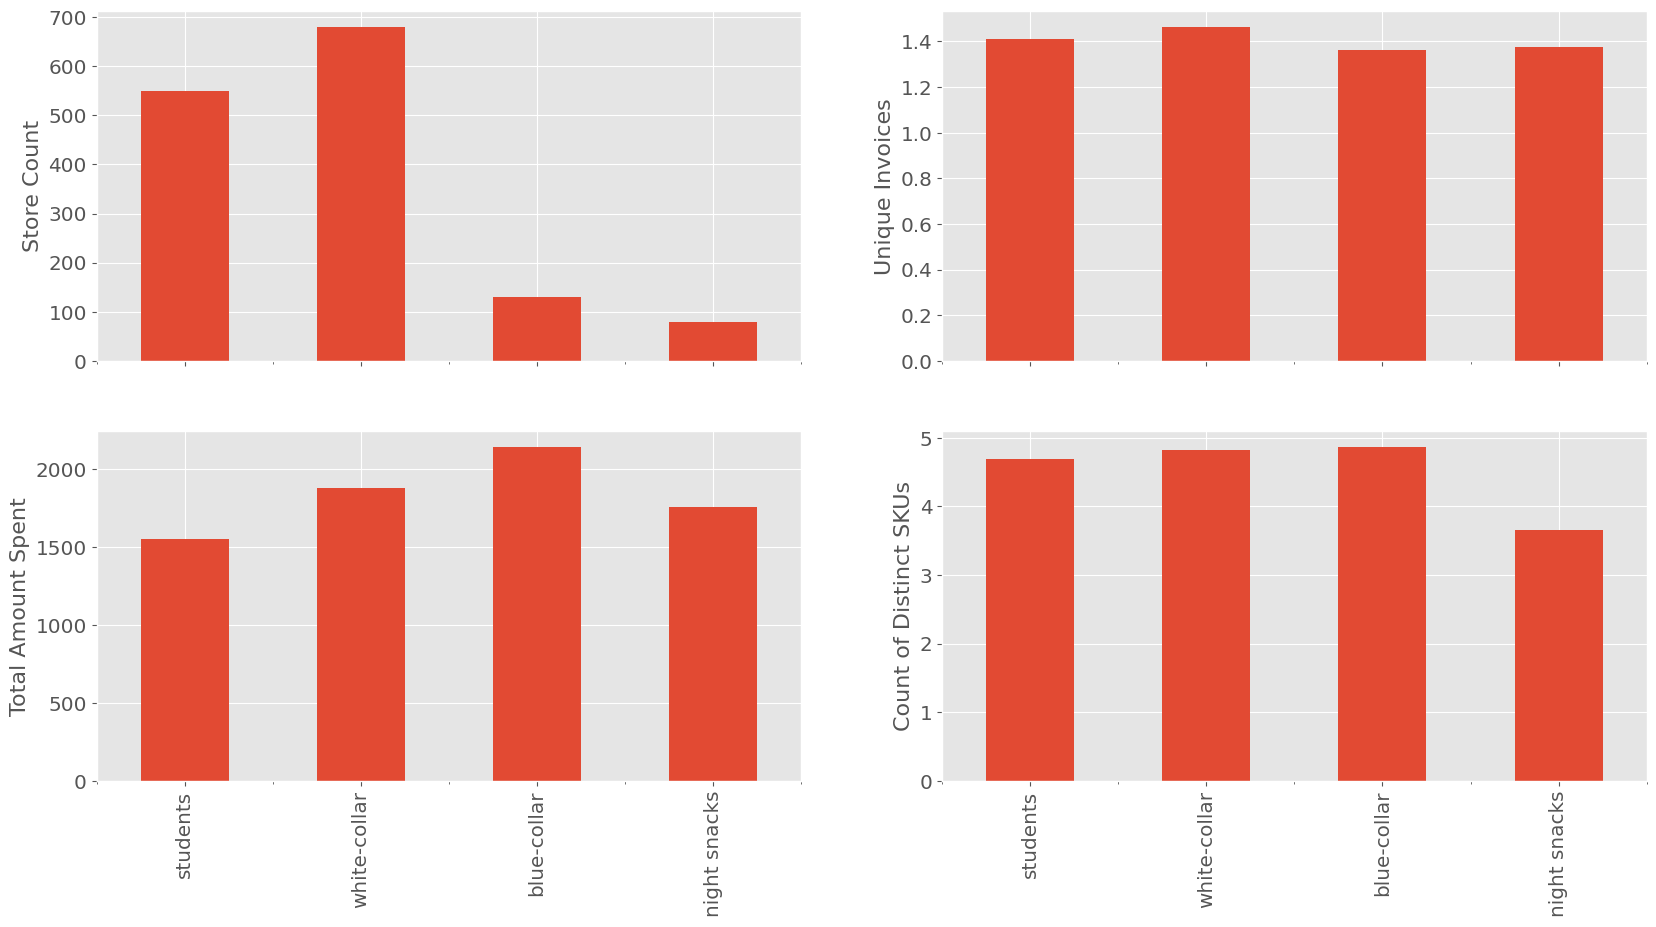

In [17]:
total_cols = 2
total_rows = len(final_df.columns) // 2 + (len(final_df.columns) % 2 > 0)
fig, axs = plt.subplots(total_rows, total_cols, sharex = True)
plt.suptitle("Per month metrics for target demographics", fontsize=20, horizontalalignment='left', x=0.1, y=.95)
i = 0
for name in final_df.columns:
    row_index = i // 2
    col_index = 1 if i % 2 > 0 else 0
    final_df[name].plot(ax = axs[row_index][col_index], kind="bar")
    axs[row_index][col_index].set_ylabel(name, fontsize=16)
    i += 1